#### Simple RNN

We're going to train a simple RNN to do **time-series prediction**. Given some set of input data, it should be able to generate a prediction for the next time step!

> * First, we'll create our data
* Then, define an RNN in PyTorch
* Finally, we'll train our network and see how it performs

In [1]:
#Import resources
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
%matplotlib inline

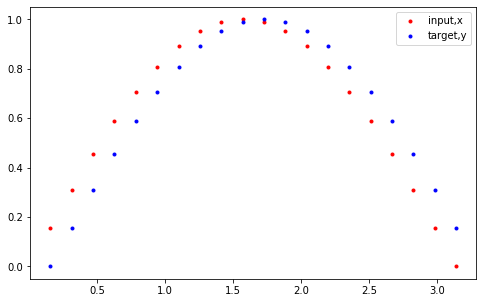

In [2]:
#Create data
plt.figure(figsize=(8,5))
#DEfine how many times steps/data pts are in one batch of data
seq_length=20
#Generate evenly spaced data pts
time_steps=np.linspace(0,np.pi,seq_length+1)
data=np.sin(time_steps)
data.resize((seq_length+1,1))
#All except last pice of data
y=data[:-1]
#All excepte first
x=data[1:]
#Show  x data
plt.plot(time_steps[1:],x,'r.',label='input,x')
#Show y data
plt.plot(time_steps[1:],y,'b.',label='target,y')
plt.legend(loc='best')
plt.show()

###### Define the RNN

We define an RNN in PyTorch. We'll use `nn.RNN` to create an RNN layer, then we'll add a last, fully-connected layer to get the output size that we want. An RNN takes in a number of parameters:
* **input_size** - the size of the input
* **hidden_dim** - the number of features in the RNN output and in the hidden state
* **n_layers** - the number of layers that make up the RNN, typically 1-3; greater than 1 means that you'll create a stacked RNN
* **batch_first** - whether or not the input/output of the RNN will have the batch_size as the first dimension (batch_size, seq_length, hidden_dim)

Take a look at the [RNN documentation](https://pytorch.org/docs/stable/nn.html#rnn) to read more about recurrent layers.

In [3]:
class RNN(nn.Module):
    def __init__(self,input_size,output_size,hidden_dim,n_layers):
        super(RNN,self).__init__()
        
        self.hidden_dim=hidden_dim
        
        #Define RNN with parameters(batch_first means first dim of input & output will be batch_size)
        self.rnn=nn.RNN(input_size,hidden_dim,n_layers,batch_first=True)
        
        #Define last,fully-connected layer
        self.fc=nn.Linear(hidden_dim,output_size)
    
    def forward(self,x,hidden):
        #x(batch_size,seq_lenght,input_size)
        #Hidden(n_layers,batch_size,hidden_size)
        #r_out(batch_+size,time_step,hidden_size)
        batch_size=x.size(0)
        
        #Get RNN outputs
        r_out,hidden=self.rnn(x,hidden)
        
        #Shape output to be (batch_size*seq_lenght,hidden_dim)
        r_out=r_out.view(-1,self.hidden_dim)
        
        #Get final output
        output=self.fc(r_out)
        
        return output,hidden

###### Check the input and output dimensions

In [4]:
#Test dimension as expected
test_rnn=RNN(input_size=1,output_size=1,hidden_dim=10,n_layers=2)
#Generate evenly spaced, test data pts
time_steps=np.linspace(0,np.pi,seq_length)
data=np.sin(time_steps)
data.resize((seq_length,1))
#Give batch_size of 1 as first dimension
test_input=torch.Tensor(data).unsqueeze(0)
print('input size: ',test_input.size())
#Test out rnn size
test_out,test_h=test_rnn(test_input,None)
print('Output size: ',test_out.size())
print('Hidden state size: ',test_h.size())

input size:  torch.Size([1, 20, 1])
Output size:  torch.Size([20, 1])
Hidden state size:  torch.Size([2, 1, 10])


###### Training the RNN

In [5]:
#DEfine hyperparameters
input_size=1 
output_size=1
hidden_dim=32
n_layers=1
#Instance RNN
rnn=RNN(input_size, output_size, hidden_dim, n_layers)
print(rnn)

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


###### Loss and Optimization

This is a regression problem: can we train an RNN to accurately predict the next data point, given a current data point?

>* The data points are coordinate values, so to compare a predicted and ground_truth point, we'll use a regression loss: the mean squared error.
* It's typical to use an Adam optimizer for recurrent models.

In [6]:
#MSE loss
criterion=nn.MSELoss()
#Adam optimizer with learning rate 0.01
optimizer=torch.optim.Adam(rnn.parameters(),lr=0.01)

###### Defining the training function

This function takes in an rnn, a number of steps to train for, and returns a trained rnn. This function is also responsible for displaying the loss and the predictions, every so often.

###### Hidden State

Pay close attention to the hidden state, here:
* Before looping over a batch of training data, the hidden state is initialized
* After a new hidden state is generated by the rnn, we get the latest hidden state, and use that as input to the rnn for the following steps

In [7]:
#TRain RNN
def train(rnn,n_steps,print_every):
    #Define hidden state
    hidden=None
    for batch_i,step in enumerate(range(n_steps)):
        #Define training data
        time_steps=np.linspace(step*np.pi,(step+1)*np.pi,seq_length+1)
        data=np.sin(time_steps)
        data.resize((seq_length+1,1))
        x=data[:-1]
        y=data[1:]
        #Conver data to Tensors
        x_tensor=torch.Tensor(x).unsqueeze(0)
        y_tensor=torch.Tensor(y)
        #Output from run rnn
        prediction,hidden=rnn(x_tensor,hidden)
        #Representing Memory,making new var for hiddden &detach hidden state from its history, So no need backprogagate throug histiry
        hidden=hidden.data
        #Calculate loss
        loss=criterion(prediction,y_tensor)
        #Zero gradienrs
        optimizer.zero_grad()
        #Perform backprop & predictions
        loss.backward()
        optimizer.step()
        
        #Display loss & predictions
        if batch_i%print_every==0:
            print('Loss',loss.item())
            plt.plot(time_steps[1:],x,'r.') # input
            plt.plot(time_steps[1:],prediction.data.numpy().flatten(),'b.') # predictions
            plt.show()
            
    return rnn

Loss 0.25670096278190613


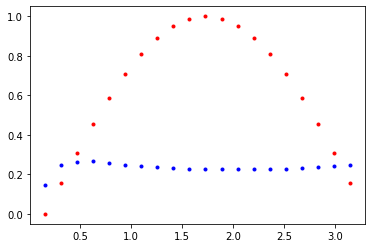

Loss 0.03250117599964142


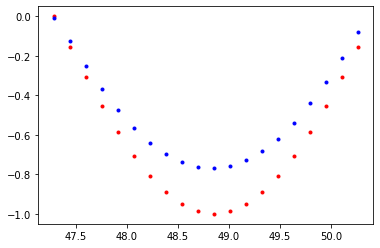

Loss 0.0008951702038757503


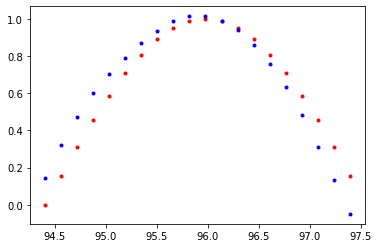

Loss 0.000688716652803123


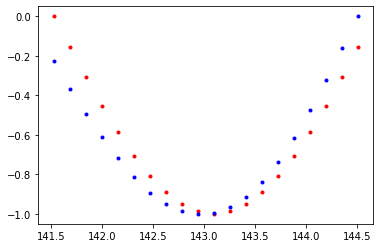

Loss 0.0003866695915348828


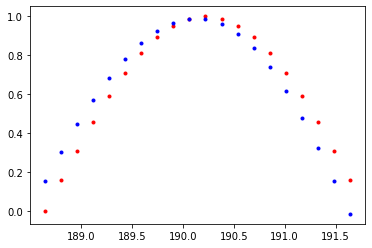

In [8]:
#Train rnn & monitor results
n_steps=75
print_every=15
trained_rnn=train(rnn,n_steps,print_every)